In [2]:
import os
import ipywidgets as widgets
import numpy as np
import pandas as pd
import scipy.sparse
from IPython.display import display
from ipywidgets import interact

%matplotlib inline
from matplotlib import pyplot as plt

from utils.metrics.metric import evaluate_classifications, evaluate_probabilities
%load_ext autoreload
%autoreload 2

# Data preparation

First split the orig_dataset into train and test set, then we need to
pre-process the transcript data

This includes, cleaning text, stemming and lemmatization

In [3]:
from prepare_data import prepare_original_data

# YOU MAY NEED TO SET THE LOCATION OF THE DATASET IN oneinamillion/resources.py.
orig_dataset, mult_lbl_enc, y_hot = prepare_original_data()

[nltk_data] Downloading package wordnet to /Users/es1595/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


loading codes from PE...


[nltk_data] Downloading package punkt to /Users/es1595/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
The current IDs only have record documents.
['011119' '020105' '030501' '030509' '030510' '050609' '050717' '050719'
 '071010' '071211' '081310' '081608' '081610' '091410' '091411' '091416'
 '101705' '101707' '111906' '111908' '112004' '122110']
The current IDs only have transcript documents.
['-081308' '010103' '010105' '020107' '030501(p.2)' '030501(p1)'
 '030509(p.1)' '030509(p.2)' '030510 (p.1)' '030510 (p.2)' '040417'
 '050605' '050609a' '050717 (Dr reads wrong number)' '060806' '060811'
 '060812' '060906' '071002' '071010(a)' '071012' '071211 (Part 1 of 2)'
 '071211 (Part 2 of 2)' '081310(b)' '081310(c)' '081310a' '081601'
 '081606' '081608 (1 of 2)' '081608 (2 of 2)' '091402' '091404' '091405'
 '091410 & 091411' '091503' '101705 and 101707' '101801' '111906 (2of2)'
 '111906(1 of 2)' '112002' '112004 & 1112005' '112014' '200105' '50719']


RDSF base directory located at /Volumes/NLP_One_In_A_Million
16 classification categories: ['A' 'B' 'D' 'F' 'H' 'K' 'L' 'N' 'P' 'R' 'S' 'T' 'U' 'W' 'X' 'Y']


In [4]:
labels = {}
for codes in orig_dataset['codes']:
    #print(codes)
    for code in codes:
        if code not in labels:
            labels[code] = 0
            
        labels[code] += 1
        
labels

{'U': 18,
 'B': 8,
 'S': 35,
 'P': 51,
 'Y': 7,
 'T': 26,
 'A': 15,
 'L': 69,
 'W': 11,
 'D': 44,
 'N': 20,
 'K': 34,
 'R': 37,
 'X': 14,
 'H': 11,
 'F': 5}

# Medical Code descriptions

In [5]:
selected_mode = None
modes = ['ICPC only', 'CKS only', 'ICPC and CKS']
def control_description(mode=modes[0]):
    global selected_mode
    selected_mode = mode

interact(control_description, mode=modes)

interactive(children=(Dropdown(description='mode', options=('ICPC only', 'CKS only', 'ICPC and CKS'), value='I…

<function __main__.control_description(mode='ICPC only')>

In [6]:
# interaction donot work for me
selected_mode = 'CKS only'

In [7]:
from prepare_data import load_descriptions

# If loading the ICPC descriptions, we take three columns: inclusion, exclusion, consider.
# If loading the CKS descriptions (which are mapped to corresponding ICPC codes), 
# we take the text from subheadings defined in the default_headings_to_include variable in 
# oneinamillion/clinical_codes/cks.py 

description_corpus = load_descriptions(selected_mode)

In [8]:
from prepare_data import load_descriptions

# If loading the ICPC descriptions, we take three columns: inclusion, exclusion, 

description_corpus = load_descriptions(selected_mode)

In [9]:
description_corpus

A    adverse drug reaction (adr) defined as:an unwa...
B    vitamin b12 deficiencybody store vitamin b12 r...
D    primary anal fissure clear underlying cause.ac...
F    age-related macular degeneration (amd) potenti...
H    cholesteatoma abnormal accumulation squamous e...
K    angina pain (or constricting discomfort) chest...
L    tendinopathy term describing pain, swelling, i...
N    overall uk, neisseria meningitidis (meningococ...
P    exact cause attention deficit hyperactivity di...
R    development allergic rhinitis mediated genetic...
S    pathogenesis acne completely understood though...
T    western countries, addison's disease commonly ...
U    cause acute kidney injury divided into:pre-ren...
W    depression refers spectrum mental health probl...
X    cause primary amenorrhoea normal secondary sex...
Y    balanitis may caused range different condition...
Name: keyword, dtype: object

# Bag of words representations

This section extracts vector representations of the ICPC code descriptions and transcripts and loads a set of stopwords. It works like this:

- Apply TF-IDF to ICPC code descriptions
- Exclude the stopwords
- Include both unigrams and bigrams
- Keeps only the top 5000 features with the highest scores

In [10]:
from utils.stopwords import get_medical_stopwords, get_custom_stopwords, get_english_stopwords
medical_stopwords = get_medical_stopwords()
custom_stopwords = get_custom_stopwords()
english_stopwords = get_english_stopwords()

use_med, use_cus, use_eng = False, False, False
stopwords = []

def update_stopwords():
    global stopwords
    stopwords = []
    if use_med:
        stopwords += medical_stopwords
    if use_cus:
        stopwords += custom_stopwords
    if use_eng:
        stopwords += english_stopwords
    # display(f"number of stopwords: {len(stopwords)}")

def set_stopwords(m,c,e):
    global use_med, use_cus, use_eng
    use_med = m
    use_cus = c
    use_eng = e
    update_stopwords()

interact(set_stopwords, m=True, c=True, e=False)

interactive(children=(Checkbox(value=True, description='m'), Checkbox(value=True, description='c'), Checkbox(v…

<function __main__.set_stopwords(m, c, e)>

In [11]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_description_vectors(description_corpus, stopwords):
    max_features=5000

    text_vectorizer = TfidfVectorizer(ngram_range=(1,2), stop_words=stopwords, max_features=max_features)
    description_vec = text_vectorizer.fit_transform(description_corpus)
    # print(f"icpc description bag-of-word matrix shape: {description_vec.shape}")
    vec_vocab = text_vectorizer.vocabulary_ # dictionary that contain the BOW tokens

    # print(f"bag-of-word tokens: {', '.join(list(vec_vocab.keys())[:5])}...")
    # print(f"vocabulary size: {len(vec_vocab)}")

    return description_vec, text_vectorizer

# Feature vectors for the descriptions
description_vec, text_vectorizer = get_description_vectors(description_corpus, stopwords)

In [12]:
# Get the labels for each description in one-hot-encoding format
y = [[i] for i in description_corpus.index]
y_desc = mult_lbl_enc.fit_transform(y)
print(y_desc)

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]]


In [31]:
# Get the transcript data and extract the feature vectors for it.

key = 'transcript__conversation_both'
# key = 'transcript__conversation_gp'
# key = 'transcript__conversation_patient'
transcript_data = orig_dataset[key]
transcript_test = text_vectorizer.transform(transcript_data)

# Classifiers

This section defines classification functions that can be used in the following experiments.

### NB classifier

In [14]:
from sklearn.naive_bayes import MultinomialNB

def run_multiclass_naive_bayes(X_train, y_train, X_test):
    # Each transcript can have one label.
    
    clf = MultinomialNB(alpha=0.001, fit_prior=False)
    clf.fit(X_train, np.argmax(y_train, 1))

    y_pred_probs = clf.predict_proba(X_test)
    
    nmissing_classes = y_desc.shape[1] - y_pred_probs.shape[1]
    if nmissing_classes:
        y_missing = np.zeros((y_pred_probs.shape[0], nmissing_classes))
        y_pred_probs = np.concatenate((y_pred_probs, y_missing), axis=1)

    y_pred_mat = y_pred_probs > 0.1

        
    return y_pred_mat, y_pred_probs

In [15]:
def run_binary_naive_bayes(X_train, y_train, X_test):
    # Consider applying each label to every transcript, i.e., a binary decision per code
    
    nclasses = y_train.shape[1]

    y_pred_mat = np.zeros((X_test.shape[0], nclasses))
    y_pred_probs = np.zeros((X_test.shape[0], nclasses))

    for c in range(nclasses):
        # iterate over the classes and make a classifier for each class

        clf = MultinomialNB(alpha=0.001)
        clf.fit(X_train, y_train[:, c])

        y_te_pred_c = clf.predict(X_test)
        # y_pred_mat[:, c] = y_te_pred_c

        y_pred_probs[:, c] = clf.predict_proba(X_test)[:, 1]
        y_pred_mat[:, c] = y_pred_probs[:, c] > 0.1

    return y_pred_mat, y_pred_probs

### SVM classifier

In [16]:
from sklearn.svm import SVC

def run_multiclass_svm(X_train, y_train, X_test):
    nclasses = y_desc.shape[1]

    clf = SVC(kernel='rbf', C=2)

    clf.fit(X_train, np.argmax(y_train, 1))

    y_pred = clf.predict(X_test)
    y_pred_probs = clf.decision_function(X_test)
    
    nmissing_classes = y_desc.shape[1] - y_pred_probs.shape[1]
    if nmissing_classes:
        y_missing = np.zeros((y_pred_probs.shape[0], nmissing_classes))
        y_pred_probs = np.concatenate((y_pred_probs, y_missing), axis=1)

    y_pred_mat = np.zeros((y_pred.shape[0], nclasses))
    y_pred_mat[np.arange(y_pred.shape[0]), y_pred] = 1

    return y_pred_mat, y_pred_probs

In [17]:
from scipy.special import expit

def run_binary_svm(X_train, y_train, X_test):
    nclasses = y_train.shape[1]

    y_pred_mat = np.zeros((X_test.shape[0], nclasses))
    y_pred_probs = np.zeros((X_test.shape[0], nclasses))

    for c in range(nclasses):
        # iterate over the classes and make a classifier for each class

        clf = SVC(kernel='rbf', C=2)
        clf.fit(X_train, y_train[:, c])

        y_te_pred_c = clf.predict(X_test)
        
        y_pred_probs[:, c] = clf.decision_function(X_test)

        y_pred_mat[:, c] = expit(y_pred_probs[:, c]) > 0.5
        
    return y_pred_mat, y_pred_probs

### Nearest Centroid and Nearest Neighbours

In [18]:
from sklearn.neighbors import NearestCentroid
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score


def run_nearest_centroid(X_train, y_train, X_test):
    nc_clf = NearestCentroid(metric='euclidean')
    nc_clf.fit(X_train, np.argmax(y_train, 1))
    y_pred = nc_clf.predict(X_test)    
    
    y_pred_mat = np.zeros((y_pred.shape[0], y_train.shape[1]))
    y_pred_mat[np.arange(y_pred.shape[0]), y_pred] = 1
        
    return y_pred_mat, y_pred_mat


def run_nearest_neighbors(X_train, y_train, X_test, n_neighbors=3):

    kn_clf = KNeighborsClassifier(n_neighbors=n_neighbors, weights='distance', metric='cosine')
    kn_clf.fit(X_train, np.argmax(y_train, 1))
        
    y_pred = kn_clf.predict(X_test)
    y_pred_mat = np.zeros((y_pred.shape[0], y_desc.shape[1]))
    y_pred_mat[np.arange(y_pred.shape[0]), y_pred] = 1
        
    y_probs = kn_clf.predict_proba(X_test)
        
    nmissing_classes = y_desc.shape[1] - y_probs.shape[1]
    if nmissing_classes:
        y_missing = np.zeros((y_probs.shape[0], nmissing_classes))
        y_probs = np.concatenate((y_probs, y_missing), axis=1)

    return y_pred_mat, y_probs

# Distant Supervison

In this setting, we use the code descriptions as our training data and test on the whole set of transcripts.

## Coarse-grained classification

Train and test with coarse-grained ICPC codes as the class labels.

### NB Classifier

In [19]:
y_pred_mat, y_pred_probs = run_multiclass_naive_bayes(description_vec, y_desc, transcript_test)

print("Multiclass NB: Performance on all classes:")
print(evaluate_classifications(y_hot, y_pred_mat, mult_lbl_enc.classes_))
print(evaluate_probabilities(y_hot, y_pred_probs))

print("Multiclass NB: Performance without the 'General' class:")
print(evaluate_classifications(y_hot[:, 1:], y_pred_mat[:, 1:], mult_lbl_enc.classes_[1:]))
print(evaluate_probabilities(y_hot[:, 1:], y_pred_probs[:, 1:]))

Multiclass NB: Performance on all classes:
0.34045860347828805
0.780024367418094
Multiclass NB: Performance without the 'General' class:
0.3570952376495678
0.7940365739232156


In [20]:
y_pred_mat, y_pred_probs = run_binary_naive_bayes(description_vec, y_desc, transcript_test)
print("Binary NB: Performance on all classes:")
print(evaluate_classifications(y_hot, y_pred_mat, mult_lbl_enc.classes_))
print(evaluate_probabilities(y_hot, y_pred_probs))

Binary NB: Performance on all classes:
0.18001808186405166
0.751845385355465


In [21]:
print("Binary NB: Performance without the 'General' class:")
print(evaluate_classifications(y_hot[:, 1:], y_pred_mat[:, 1:], mult_lbl_enc.classes_[1:]))
print(evaluate_probabilities(y_hot[:, 1:], y_pred_probs[:, 1:]))

Binary NB: Performance without the 'General' class:
0.19201928732165513
0.7766985697759882


#### SVM Classifier

In [22]:
# multiclass svm
y_pred_mat, y_pred_probs = run_multiclass_svm(description_vec, y_desc, transcript_test)

print("Multiclass SVM: Performance on all classes:")
print(evaluate_classifications(y_hot, y_pred_mat, mult_lbl_enc.classes_))
print(evaluate_probabilities(y_hot, y_pred_probs))

print("Multiclass SVM: Performance without the 'General' class:")
print(evaluate_classifications(y_hot[:, 1:], y_pred_mat[:, 1:], mult_lbl_enc.classes_[1:]))
print(evaluate_probabilities(y_hot[:, 1:], y_pred_probs[:, 1:]))

Multiclass SVM: Performance on all classes:
0.3619733144442262
0.8335111641319247
Multiclass SVM: Performance without the 'General' class:
0.3861048687405079
0.8618404798359578


In [23]:
# binary svm
y_pred_mat, y_pred_probs = run_binary_svm(description_vec, y_desc, transcript_test)

print("Binary SVM: Performance on all classes:")
print(evaluate_classifications(y_hot, y_pred_mat, mult_lbl_enc.classes_))
print(evaluate_probabilities(y_hot, y_pred_probs))

print("Binary SVM: Performance without the 'General' class:")
print(evaluate_classifications(y_hot[:, 1:], y_pred_mat[:, 1:], mult_lbl_enc.classes_[1:]))
print(evaluate_probabilities(y_hot[:, 1:], y_pred_probs[:, 1:]))

Binary SVM: Performance on all classes:
0.0
0.8400578867816496
Binary SVM: Performance without the 'General' class:
0.0
0.8622204760591564


### Nearest Centroid classifier

Define distance and nearest centroid classifiers.

In [46]:
y_pred_mat, y_pred_probs = run_nearest_centroid(description_vec, y_desc, transcript_test)

print("Nearest centroid: Performance on all classes:")
print(evaluate_classifications(y_hot, y_pred_mat, mult_lbl_enc.classes_))
print(evaluate_probabilities(y_hot, y_pred_probs))

print("Nearest centroid: Performance without the 'General' class:")
print(evaluate_classifications(y_hot[:, 1:], y_pred_mat[:, 1:], mult_lbl_enc.classes_[1:]))
print(evaluate_probabilities(y_hot[:, 1:], y_pred_probs[:, 1:]))

# # # for distant supervision, only consider the nearest description. This is identical to nearest centroid so skip it here.
# y_pred_mat, y_pred_probs = run_nearest_neighbors(description_vec, y_desc, transcript_test, n_neighbors=1)  

# print(evaluate_classifications(y_hot, y_pred_mat, mult_lbl_enc.classes_))
# print(evaluate_classifications(y_hot[:, 1:], y_pred_mat[:, 1:], mult_lbl_enc.classes_[1:]))

Nearest centroid: Performance on all classes:
0.3619733144442262
0.6359371566301026
Nearest centroid: Performance without the 'General' class:
0.3861048687405079
0.6454440781832207


# Analysis

Define some functions we can use to compare our classifiers' predictions to the ground truth.

In [25]:
def get_idxes_with_cat(_y_train: np.ndarray, code:str):
    # Return the indexes of examples from the training set that have the chosen code as a gold label
    
    y_train_raw = mult_lbl_enc.inverse_transform(_y_train)
    return [i for i,cs in enumerate(y_train_raw) if code in cs]


def get_truth_pred_pairs(_y_train, _y_pred, indices):

    # Get true labels for selected instances
    truth = mult_lbl_enc.inverse_transform(_y_train[indices])
        
    # Get predictions for selected instances
    pred = mult_lbl_enc.inverse_transform(_y_pred[indices])
        
    # Return a table 
    data = list(zip(indices, truth, pred))
    return pd.DataFrame(data, columns=['id', 'truth', 'predicted'])


def show_truth_pred_tbl(code):
    # Code: the selected ICPC code
    
    # gold_mat: choose the gold labels as a one-hot encoded matrix
    gold_mat = y_hot
    
    # get the transcripts from the train split with the chosen code
    cat_idxes = get_idxes_with_cat(gold_mat, code)  
    
    # Get a table showing the predictions and true labels
    return get_truth_pred_pairs(gold_mat, y_pred_mat, cat_idxes)


interact(show_truth_pred_tbl, code=mult_lbl_enc.classes_)  # use interactive UI to set the code from any one of the ICPC codes

interactive(children=(Dropdown(description='code', options=('A', 'B', 'D', 'F', 'H', 'K', 'L', 'N', 'P', 'R', …

<function __main__.show_truth_pred_tbl(code)>

interactive(children=(Dropdown(description='cat', options=('A', 'B', 'D', 'F', 'H', 'K', 'L', 'N', 'P', 'R', '…

<function __main__.plot_explain_category(cat: str)>

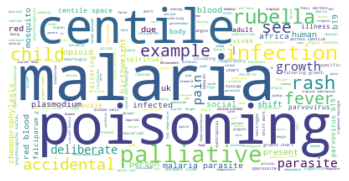

In [26]:
from wordcloud import WordCloud

# Explain a category -- show the keywords from the descriptions as a word cloud

lookup = [x for _,x in sorted(zip(text_vectorizer.vocabulary_.values(), text_vectorizer.vocabulary_.keys()))]
features_arr = np.array(text_vectorizer.get_feature_names())

def explain_bow_vector(vec:scipy.sparse.csr_matrix, ax=plt):
    # _, idxs = scipy.sparse.csr_matrix.nonzero(vec)
    # words = [lookup[k] for k in idxs]
    # word_cloud = WordCloud().generate(' '.join(words))
    test = pd.DataFrame(vec.todense(), columns=features_arr).T.to_dict()[0]
    word_cloud = WordCloud(background_color="white").generate_from_frequencies(test)
    ax.imshow(word_cloud, interpolation='bilinear')
    ax.axis("off")

def explain_category(cat:str, ax=plt):
    target = list(mult_lbl_enc.classes_).index(cat)
    target = description_vec[target]
    explain_bow_vector(target, ax=ax)

def plot_explain_category(cat:str):
    explain_category(cat)

interact(plot_explain_category, cat=mult_lbl_enc.classes_)

interactive(children=(Dropdown(description='_cat', options=('A', 'B', 'D', 'F', 'H', 'K', 'L', 'N', 'P', 'R', …

<function __main__.view_record(_cat, _id)>

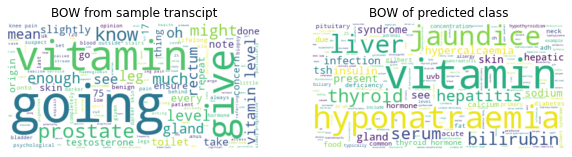

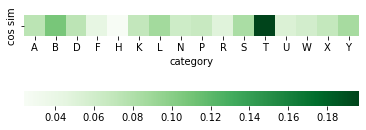

In [27]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# Choose the instances we will be using -- can be set to y_hot for whole dataset or y_train for the training split
gold_mat = y_hot  # y_train  # one-hot encoding
# Can be set to transcript_test for whole dataset or X_train for training split
transcript_vec = transcript_test  # X_train
# Can be set to orig_dataset for whole dataset or train_set for training split
transcript_dataframe = orig_dataset

cat_dropdown = widgets.Dropdown(options=mult_lbl_enc.classes_)
id_dropdown = widgets.Dropdown(options=get_idxes_with_cat(gold_mat, cat_dropdown.value))

def refresh_id_dropdown(*args):
    id_dropdown.options = get_idxes_with_cat(gold_mat, cat_dropdown.value)

cat_dropdown.observe(refresh_id_dropdown, 'value')

def show_cosine_similarity(_id):   
    cos_sim = cosine_similarity(transcript_vec[_id], description_vec)[0]
    cos_sim = pd.DataFrame(list(zip(mult_lbl_enc.classes_, cos_sim)), columns=['category', 'cos sim'])
    cos_sim = cos_sim.set_index('category').T
    grid_kws = {"height_ratios": (.9, .05), "hspace": -0.5}
    f, (ax, cbar_ax) = plt.subplots(2, gridspec_kw=grid_kws)
    sns.heatmap(cos_sim, square=True, ax=ax,
                cbar_ax=cbar_ax,
                cbar_kws={"orientation": "horizontal"},
                cmap='Greens')

    
def show_keywords_true_pred(_id, _cat):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.title.set_text('BOW from sample transcipt')
    ax2.title.set_text('BOW of predicted class')            
    explain_bow_vector(transcript_vec[_id], ax=ax1)
    explain_category(_cat, ax=ax2)

    
def view_record(_cat, _id):
    # _id: index of a selected transcript instance
    # _cat: category to investigate. We can select instances with this category as their true label.?
    
    global test
    
    # get the predicted category labels for the selected instance
    pred_cat = mult_lbl_enc.inverse_transform(np.array(y_pred_mat)[_id:_id+1])[0][0]
    
    # get the selected instance. Change this to train_set if using the training split.
    record = transcript_dataframe.iloc[_id]
    
    # get the vector of the selected transcript
    record
    
    info = [f"Index: {_id}",
           f"Id: {record['record_id']}",
           f"Actual: {mult_lbl_enc.inverse_transform(gold_mat[_id:_id+1])}",
           f"Predicted: {pred_cat}"]
    display(*info)
    
    # show keywords from the transcript and from the description vector of the predicted class
    show_keywords_true_pred(_id, pred_cat)    
    
    # Compute similarity between the description vectors for each class and the vector of the selected transcript
    show_cosine_similarity(_id)
    
interact(view_record, _cat=cat_dropdown, _id=id_dropdown)

multilabel_confusion_matrix:


<ipython-input-28-26a701f12261>:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


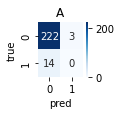

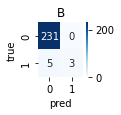

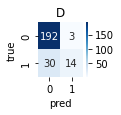

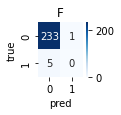

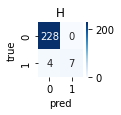

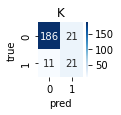

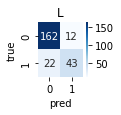

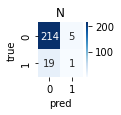

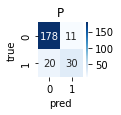

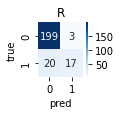

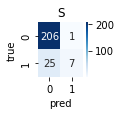

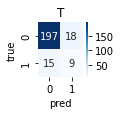

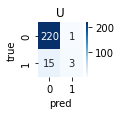

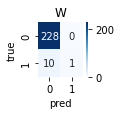

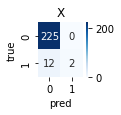

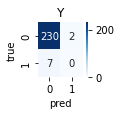

In [28]:
from sklearn.metrics import multilabel_confusion_matrix

# Note: print statements does not work in PyCharm

def plot_multilabel_conf_matrix(targets, predictions):
    print(f"multilabel_confusion_matrix:")
    conf_mat = multilabel_confusion_matrix(targets, predictions)
   
    for c, (cls, mat) in enumerate(zip(mult_lbl_enc.classes_, conf_mat)):
        fig = plt.figure(figsize=(1,1))
        ax = fig.add_subplot()
                
        ax.set_title(cls)
        sns.heatmap(mat, ax=ax, cmap='Blues', annot=True, fmt="d")
        ax.set_xlabel('pred')
        ax.set_ylabel('true')
        fig.show()

plot_multilabel_conf_matrix(y_hot, y_pred_mat)

## Fine-grained classification

Here we train and predict the CKS topics. To evaluated, we map predictions back to ICPC codes and use the test labels.

In [29]:
import json
from oneinamillion.resources import DL_DATA, ICPC2CKS, CKS_DESC, PCC_CODES_DIR, PCC_CKS_DIR
from sklearn.preprocessing import MultiLabelBinarizer
from utils.utils import prediction_cks2icpc

In [30]:
# load topics trained in DL methods to keep consitent
topics_file = os.path.join(DL_DATA, 'fg_label2id.json')
with open(topics_file, 'r') as f:
    selected_topics = json.load(f)
# load health topics
health_topics = pd.read_csv(os.path.join(PCC_CKS_DIR, CKS_DESC), index_col=0)
health_topics = health_topics.loc[selected_topics]

description_vec, text_vectorizer = get_description_vectors(health_topics['topics'], stopwords)
# obtain labels
mult_lbl_enc2 = MultiLabelBinarizer()
y = [[i] for i in health_topics.index]
y_desc = mult_lbl_enc2.fit_transform(y)

# obtain test data
transcript_test = text_vectorizer.transform(transcript_data)

<ipython-input-30-d8f8db1c5356>:7: FutureWarning: Passing a dict as an indexer is deprecated and will raise in a future version. Use a list instead.
  health_topics = health_topics.loc[selected_topics]


In [31]:
health_topics['topics']

Superficial vein thrombosis (superficial thrombophlebitis)    superficial vein thrombosis (also known superf...
Bipolar disorder                                              bipolar disorder thought caused interplay gene...
Carpal tunnel syndrome                                        people cause carpal tunnel syndrome known.anyt...
Cholesteatoma                                                 cholesteatoma abnormal accumulation squamous e...
DVT prevention for travellers                                 deep vein thrombosis (dvt) term used describe ...
                                                                                    ...                        
Conjunctivitis - allergic                                     allergic conjunctivitis caused immunoglobulin ...
Urethritis - male                                             urethritis commonly (but always) caused sexual...
Herpes simplex - oral                                         oral herpes simplex virus (hsv) usually ca

#### NB Classifier 

In [32]:
y_pred_mat, y_pred_probs = run_binary_naive_bayes(description_vec, y_desc, transcript_test)
# convert label_id to class names
pred_labels = mult_lbl_enc2.inverse_transform(y_pred_mat)

map_file = os.path.join(PCC_CKS_DIR, ICPC2CKS)
# create a fake label2name
label2name = {label:label for label in mult_lbl_enc.classes_}
# map cks to icpc
mapped_predictions = prediction_cks2icpc(map_file, pred_labels, label2name)


predictions = mult_lbl_enc.transform(mapped_predictions)

print('Binary NB fine-grained: ')
print(evaluate_classifications(y_hot, predictions, mult_lbl_enc.classes_))

Binary NB fine-grained: 
0.003787878787878788


In [33]:
y_pred_mat, y_pred_probs = run_multiclass_naive_bayes(description_vec, y_desc, transcript_test)
# convert label_id to class names
pred_labels = mult_lbl_enc2.inverse_transform(y_pred_mat)

map_file = os.path.join(PCC_CKS_DIR, ICPC2CKS)
# create a fake label2name
label2name = {label:label for label in mult_lbl_enc.classes_}
# map cks to icpc
mapped_predictions = prediction_cks2icpc(map_file, pred_labels, label2name)


predictions = mult_lbl_enc.transform(mapped_predictions)

print('Multiclass NB fine-grained: ')
print(evaluate_classifications(y_hot, predictions, mult_lbl_enc.classes_))

Multiclass NB fine-grained: 
0.23201562287071104


In [34]:
y_pred_mat, y_pred_probs = run_multiclass_svm(description_vec, y_desc, transcript_test)
pred_labels = mult_lbl_enc2.inverse_transform(y_pred_mat)
map_file = os.path.join(PCC_CKS_DIR, ICPC2CKS)
# create a fake label2name
label2name = {label:label for label in mult_lbl_enc.classes_}
# map cks to icpc
mapped_predictions = prediction_cks2icpc(map_file, pred_labels, label2name)
predictions = mult_lbl_enc.transform(mapped_predictions)

print('Multiclass SVM fine-grained: ')
print(evaluate_classifications(y_hot, predictions, mult_lbl_enc.classes_))

Multiclass SVM fine-grained: 
0.35516238803557787


In [35]:
y_pred_mat, y_pred_probs = run_nearest_centroid(description_vec, y_desc, transcript_test)
pred_labels = mult_lbl_enc2.inverse_transform(y_pred_mat)
map_file = os.path.join(PCC_CKS_DIR, ICPC2CKS)
# create a fake label2name
label2name = {label:label for label in mult_lbl_enc.classes_}
# map cks to icpc
mapped_predictions = prediction_cks2icpc(map_file, pred_labels, label2name)
predictions = mult_lbl_enc.transform(mapped_predictions)

print('Nearest centroid fine-grained: ')
print(evaluate_classifications(y_hot, predictions, mult_lbl_enc.classes_))

Nearest centroid fine-grained: 
0.35516238803557787


In [36]:
# create a data frame
# Column 1: consultation ID
col1 = orig_dataset['record_id'].to_numpy()[:, None]

# Column 2: ICPC coarse-grained labels
col2 = orig_dataset['icpc_codes'].to_numpy()[:, None]

# Column 3: CKS topics that were chosen by nearest centroid
col3 = np.array([labels[0] for labels in pred_labels])[:, None]
print(col3.shape)
# col3 = pd.DataFrame(col3, 

df = pd.DataFrame(np.concatenate((col1, col2, col3), axis=1), columns=['record_id', 'icpc_codes', 'cks_nearest_centroid_prediction']) 

print(df)

df.to_csv('./fine-grained_nearest_centroid_predictions.tsv', sep='\t')

(239, 1)
    record_id             icpc_codes cks_nearest_centroid_prediction
0       30301         ['U99', 'B80']             Acute kidney injury
1       40416         ['S96', 'P76']                Autism in adults
2       20106  ['Y07', 'T91', 'A91']  Vitamin D deficiency in adults
3       50614                ['L86']              Leg ulcer - venous
4       11107         ['L99', 'W11']                      Chest pain
..        ...                    ...                             ...
234     50715                ['S80']               Itch - widespread
235     40414         ['A11', 'A91']                      Chest pain
236    101703         ['T93', 'K86']                    Hypertension
237     91504  ['P76', 'L15', 'T82']          Depression in children
238     50607                ['X11']                       Menopause

[239 rows x 3 columns]


In [37]:
from utils.utils import prediction_cks2icpc

# Save the original mapping between CKS and ICPC as a TSV file

# list all the cks topics
cks_topics = [(topic,) for topic in mult_lbl_enc2.classes_]
# print(cks_topics)

map_file = os.path.join(PCC_CKS_DIR, ICPC2CKS)

# create a fake label2name
label2name = {label:label for label in mult_lbl_enc.classes_}

# map cks to icpc
mapped_predictions = np.array(prediction_cks2icpc(map_file, cks_topics, label2name), dtype=object)[:, None]

df = pd.DataFrame(np.concatenate((cks_topics, mapped_predictions), axis=1), columns=['cks_topic', 'icpc_codes']) 

print(df)

df.to_csv('./cks_icpc_mapping.tsv', sep='\t')

                            cks_topic icpc_codes
0               Achilles tendinopathy        [L]
1                       Acne vulgaris        [S]
2                Acute childhood limp        [L]
3                 Acute kidney injury        [U]
4                   Addison's disease        [T]
..                                ...        ...
310    Vitamin D deficiency in adults        [T]
311  Vitamin D deficiency in children        [T]
312                          Vitiligo        [S]
313                Warts - anogenital  [S, X, Y]
314                    Whooping cough        [R]

[315 rows x 2 columns]


Text(0.5, 1.0, 'bag-of-words Vector')

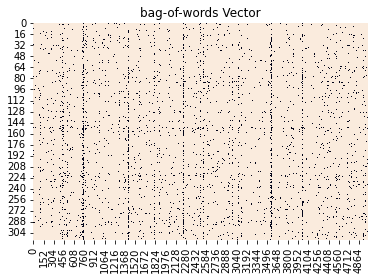

In [38]:
import seaborn as sns
sns.heatmap(description_vec.todense()==0, vmin=0, vmax=1, cbar=False).set_title('bag-of-words Vector')

In [39]:
# from wordcloud import WordCloud
# test_vec = description_vec[1].todense()
# col_names = np.array(text_vectorizer.get_feature_names())
# test = pd.DataFrame(test_vec, columns=col_names).T.to_dict()[0]
# print(test)
# word_cloud = WordCloud(background_color="white").generate_from_frequencies(test)
# plt.imshow(word_cloud)

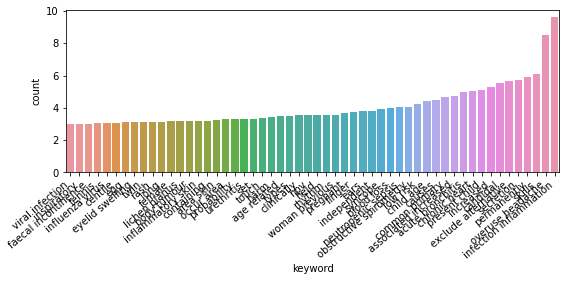

['viral infection', 'inspiratory', 'faecal incontinence', 'tennis', 'influenza virus', 'centile', 'egg', 'eyelid swelling', 'twin', 'rash', 'long', 'female', 'lichen planus', 'body tumour', 'inflammatory skin', 'containing', 'area skin', 'occur area', 'probability', 'urethritis', 'set', 'touch', 'harm', 'age related', 'types', 'clinically', 'hpv', 'held', 'rhythm', 'woman previous', 'pregnant', 'finger', 'ears', 'independent', 'syncope', 'blood loss', 'neutropenic sepsis', 'obstructive spirometry', 'low risk', 'child age', 'causes', 'common primary', 'associated increased', 'acute bronchitis', 'chronic heart', 'present child', 'increased', 'candidal', 'exclude alternative', 'secretion', 'permanently', 'skills', 'overuse headache', 'infection inflammation']


In [40]:
keyword_dist_over_train = np.array(description_vec.sum(axis=0)).flatten()

def show_common_keywords(threshold:int = 3):
    frequent_words = [[k,n] for k,n in zip(lookup, keyword_dist_over_train) if n > threshold]
    frequent_words_df = pd.DataFrame(frequent_words,columns=['keyword', 'count']).sort_values('count')

    plt.figure(figsize=(8,4))
    ax = sns.barplot(x='keyword', y='count', data=frequent_words_df)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
    plt.tight_layout()
    plt.show()

    print([k._text for k in ax.get_xticklabels()])

show_common_keywords()

# Supervision with Transcripts

Here we use 5-fold cross validation to train and test classifiers on transcript data. The descriptions are not used.

We predict the coarse-grained codes.

In [23]:
from sklearn.model_selection import StratifiedKFold

X = np.arange(orig_dataset['index'].shape[0]).reshape((-1, 1))

kfolds = StratifiedKFold(n_splits=5, random_state=3, shuffle=True)

y_desc = mult_lbl_enc.fit_transform(mult_lbl_enc.classes_)

def cross_validate(clf, key, text_vectorizer):
    
    f1s = []
    aurocs = []
    
    for train_idxs, test_idxs in kfolds.split(X, np.argmax(y_hot, 1)):

        train_set = orig_dataset.iloc[train_idxs]  
        y_train = y_hot[train_idxs]
        
        test_set = orig_dataset.iloc[test_idxs]
        y_test = y_hot[test_idxs]
        
        description_vec, text_vectorizer = get_description_vectors(description_corpus, stopwords)
        y_desc = mult_lbl_enc.fit_transform(mult_lbl_enc.classes_)
            
        X_train = text_vectorizer.transform(train_set[key])
        X_test = text_vectorizer.transform(test_set[key])
        
        y_pred_mat, y_pred_probs = clf(X_train, y_train, X_test)  # performance on training set
                
        f1_k = evaluate_classifications(y_test, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
        auroc_k = evaluate_probabilities(y_test, y_pred_probs)
        
        f1s.append(f1_k)
        aurocs.append(auroc_k)
        
    f1 = np.mean(f1s)
    auroc = np.mean(aurocs)
    
    print(f'F1 score: {f1}. AUROC: {auroc}')
        
    return f1, auroc


For `average` parameter to take the average metrics over all classes, please see [documentation](https://scikit-learn.org/stable/modules/model_evaluation.html#from-binary-to-multiclass-and-multilabel).

## Binary Naive Bayes Classifier

In [24]:
cross_validate(run_binary_naive_bayes, key, text_vectorizer)

/Users/es1595/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


F1 score: 0.29186803118924265. AUROC: 0.7728205829493369


(0.29186803118924265, 0.7728205829493369)

## Multiclass Naïve Bayes Classifier

In [43]:
cross_validate(run_multiclass_naive_bayes, key, text_vectorizer)

/Users/es1595/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


F1 score: 0.30425799910172463. AUROC: 0.7725439199103569


(0.30425799910172463, 0.7725439199103569)

## SVM Classifier

In [44]:
cross_validate(run_multiclass_svm, key, text_vectorizer)

/Users/es1595/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


F1 score: 0.18421724281269874. AUROC: 0.6832399743220912


(0.18421724281269874, 0.6832399743220912)

In [45]:
cross_validate(run_binary_svm, key, text_vectorizer)

/Users/es1595/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


F1 score: 0.1583234863598136. AUROC: 0.7685660903070616


(0.1583234863598136, 0.7685660903070616)

### Nearest neighbours

In [46]:
cross_validate(run_nearest_neighbors, key, text_vectorizer)

/Users/es1595/opt/anaconda3/envs/py39/lib/python3.9/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


F1 score: 0.15708105426751948. AUROC: 0.5881446220708885


(0.15708105426751948, 0.5881446220708885)

## Test Different Stopwords and Descriptions

In [34]:
import warnings
warnings.filterwarnings("ignore")

def tune_transcript_supervision(method):
    stopword_settings = [
         [],
         ['m'],
         ['c'],
         ['e'],
         ['m', 'c'],
         ['m', 'e'],
         ['c', 'e'],
         ['m', 'c', 'e']
    ]

    f1_matrix = np.zeros((len(stopword_settings)))
    auroc_matrix = np.zeros((len(stopword_settings)))

    for i, s in enumerate(stopword_settings):
        set_stopwords('m' in s, 'c' in s, 'e' in s)
        description_vec, text_vectorizer = get_description_vectors(description_corpus, stopwords)
        y_desc = mult_lbl_enc.fit_transform(mult_lbl_enc.classes_)

        if method == 'nearest centroid':  
            clf = run_nearest_centroid
        elif method == 'nearest neighbours':  
            clf = run_nearest_neighbors
        elif method == 'binary NB':
            clf = run_binary_naive_bayes
        elif method == 'multiclass NB':
            clf = run_multiclass_naive_bayes
        elif method == 'binary SVM':
            clf = run_binary_svm
        elif method == 'multiclass SVM':
            clf = run_multiclass_svm

        f1_matrix[i], auroc_matrix[i] = cross_validate(clf, key, text_vectorizer)

    max_idx = np.unravel_index(np.argmax(f1_matrix), f1_matrix.shape)
    selected_auroc = auroc_matrix[max_idx[0]]  # not necessarily the best, but the value we get with best f1 score
    best_tr_f1 = np.max(f1_matrix)
    best_stopwords = stopword_settings[max_idx[0]]
    print(f'Method: {method}. The best score with transcript supervision was {best_tr_f1} with {best_stopwords} stopwords and AUROC={selected_auroc}.')

    print('F1 score matrix for the different settings we tried:')
    print(f1_matrix)

    return best_tr_f1, selected_auroc, best_stopwords
    
    
    
def tune_distant_supervision(method):
    stopword_settings = [
         [],
         ['m'],
         ['c'],
         ['e'],
         ['m', 'c'],
         ['m', 'e'],
         ['c', 'e'],
         ['m', 'c', 'e']
    ]

    description_settings = ['ICPC only', 'CKS only', 'both']

    f1_matrix = np.zeros((len(stopword_settings), len(description_settings)))
    auroc_matrix = np.zeros((len(stopword_settings), len(description_settings)))

    X_test = transcript_test
    y_test = y_hot
    
    for j, selected_mode in enumerate(description_settings):
        description_corpus = load_descriptions(selected_mode, mult_lbl_enc.classes_)
        for i, s in enumerate(stopword_settings):
            set_stopwords('m' in s, 'c' in s, 'e' in s)
            description_vec, text_vectorizer = get_description_vectors(description_corpus, stopwords)
            y_desc = mult_lbl_enc.fit_transform(mult_lbl_enc.classes_)
            
            if method == 'nearest centroid':  
                clf = run_nearest_centroid
            elif method == 'nearest neighbours':  
                clf = run_nearest_neighbors
            elif method == 'binary NB':
                clf = run_binary_naive_bayes
            elif method == 'multiclass NB':
                clf = run_multiclass_naive_bayes
            elif method == 'binary SVM':
                clf = run_binary_svm
            elif method == 'multiclass SVM':
                clf = run_multiclass_svm
                
            y_pred_mat, y_pred_probs = clf(description_vec, y_desc, X_test)
            f1_matrix[i, j] = evaluate_classifications(y_test, y_pred_mat, mult_lbl_enc.classes_, show_report=False)
            auroc_matrix[i, j] = evaluate_probabilities(y_test, y_pred_probs)


    max_idx = np.unravel_index(np.argmax(f1_matrix), f1_matrix.shape)
    best_tr_f1 = np.max(f1_matrix)
    selected_auroc = auroc_matrix[max_idx[0], max_idx[1]]  # not necessarily the best, but the value we get with best f1 score
    best_stopwords = stopword_settings[max_idx[0]]
    best_desc = description_settings[max_idx[1]]
    print(f'Method: {method}. The best score with transcript supervision was {best_tr_f1} with {best_stopwords} stopwords and {best_desc} code descriptions and AUROC={selected_auroc}.')

    print('F1 score matrix for the different settings we tried:')
    print(f1_matrix)
    print(f'...rows are stopword settings, {stopword_settings}, and columns are code descriptions, {description_settings}')

    return best_tr_f1, selected_auroc, best_desc, best_stopwords


In [43]:
tr_sup_auroc = {}
tr_sup_f1scores = {}

tr_sup_stopwords = {}

dist_f1scores = {}
dist_auroc = {}

dist_descriptions = {}
dist_stopwords = {}


classifiers_to_run = [
    'nearest centroid',
    'nearest neighbours',
    'binary NB',
    'multiclass NB',
    'binary SVM', 
    'multiclass SVM'
]    

for classifier in classifiers_to_run:
    # tr_sup_f1scores[classifier], tr_sup_auroc[classifier], tr_sup_stopwords[classifier] \
        # = tune_transcript_supervision(classifier)
    
    dist_f1scores[classifier], dist_auroc[classifier], dist_descriptions[classifier], dist_stopwords[classifier] \
        = tune_distant_supervision(classifier)

Method: nearest centroid. The best score with transcript supervision was 0.3619733144442262 with ['m', 'c'] stopwords and CKS only code descriptions and AUROC=0.6359371566301026.
F1 score matrix for the different settings we tried:
[[0.05908054 0.05361481 0.07249159]
 [0.04296522 0.04112781 0.10630254]
 [0.05542252 0.03415073 0.11891096]
 [0.03780826 0.04228995 0.04327121]
 [0.0398045  0.36197331 0.09051628]
 [0.05451943 0.06523568 0.04349933]
 [0.04267562 0.03927739 0.05812541]
 [0.05557596 0.04338997 0.10326239]]
...rows are stopword settings, [[], ['m'], ['c'], ['e'], ['m', 'c'], ['m', 'e'], ['c', 'e'], ['m', 'c', 'e']], and columns are code descriptions, ['ICPC only', 'CKS only', 'both']
Method: nearest neighbours. The best score with transcript supervision was 0.3619733144442262 with ['m', 'c'] stopwords and CKS only code descriptions and AUROC=0.7405479134127408.
F1 score matrix for the different settings we tried:
[[0.05908054 0.05361481 0.07249159]
 [0.04296522 0.04112781 0.106

In [47]:
for classifier in classifiers_to_run:
    tr_sup_f1scores[classifier], tr_sup_auroc[classifier], tr_sup_stopwords[classifier] \
        = tune_transcript_supervision(classifier)

F1 score: 0.23729847463767745. AUROC: 0.5909524965825543
F1 score: 0.28240630199021305. AUROC: 0.6076040764402986
F1 score: 0.2293576786775316. AUROC: 0.5860057567895949
F1 score: 0.26249202289611495. AUROC: 0.6049791813293165
F1 score: 0.2825650778959602. AUROC: 0.6112840522078329
F1 score: 0.3001183985218428. AUROC: 0.6189661809356714
F1 score: 0.27518540120010704. AUROC: 0.6060420395341526
F1 score: 0.28592511878573257. AUROC: 0.6090502367803815
Method: nearest centroid. The best score with transcript supervision was 0.3001183985218428 with ['m', 'e'] stopwords and AUROC=0.6189661809356714.
F1 score matrix for the different settings we tried:
[0.23729847 0.2824063  0.22935768 0.26249202 0.28256508 0.3001184
 0.2751854  0.28592512]
F1 score: 0.11024362624962472. AUROC: 0.5604443001478607
F1 score: 0.1501120893282271. AUROC: 0.5890192642007855
F1 score: 0.10696035942839013. AUROC: 0.559168911925273
F1 score: 0.14878750119351142. AUROC: 0.596999167637916
F1 score: 0.15708105426751948. 

It looks like there is lots of overfitting of the classifiers above, as there is high trainign set performance and low test set performance, especially when using multiple binary classifiers. 

These results are not very meaningful. They show distant supervision, coarse-grained performance using the stop-word setting selected using the transcript-supervision setup. It would be more useful to replicate the stopword experiments with distant supervision only. This is also required to test whether CKS topics are the best source of distant supervision. 

In [48]:
tr_sup_auroc

{'nearest centroid': 0.6189661809356714,
 'nearest neighbours': 0.5860960179823788,
 'binary NB': 0.7721322347937744,
 'multiclass NB': 0.7745668560970265,
 'binary SVM': 0.7704816260032824,
 'multiclass SVM': 0.7073559090966471}

In [50]:
tr_sup_f1scores

{'nearest centroid': 0.3001183985218428,
 'nearest neighbours': 0.1750321144498776,
 'binary NB': 0.30277118954287746,
 'multiclass NB': 0.3189401035999218,
 'binary SVM': 0.18306066973457433,
 'multiclass SVM': 0.20082118856814674}

In [51]:
tr_sup_stopwords

{'nearest centroid': ['m', 'e'],
 'nearest neighbours': ['m', 'c', 'e'],
 'binary NB': ['m'],
 'multiclass NB': ['m', 'c', 'e'],
 'binary SVM': ['e'],
 'multiclass SVM': ['c', 'e']}

In [52]:
dist_f1scores

{'nearest centroid': 0.3619733144442262,
 'nearest neighbours': 0.3619733144442262,
 'binary NB': 0.18001808186405166,
 'multiclass NB': 0.34045860347828805,
 'binary SVM': 0.0,
 'multiclass SVM': 0.3619733144442262}

In [53]:
dist_auroc

{'nearest centroid': 0.6359371566301026,
 'nearest neighbours': 0.7405479134127408,
 'binary NB': 0.751845385355465,
 'multiclass NB': 0.780024367418094,
 'binary SVM': 0.49421979052028053,
 'multiclass SVM': 0.8335111641319247}

In [41]:
dist_descriptions

{'nearest centroid': 'CKS only',
 'nearest neighbours': 'CKS only',
 'binary NB': 'CKS only',
 'multiclass NB': 'CKS only',
 'binary SVM': 'ICPC only',
 'multiclass SVM': 'CKS only'}

In [42]:
dist_stopwords

{'nearest centroid': ['m', 'c'],
 'nearest neighbours': ['m', 'c'],
 'binary NB': ['m', 'c'],
 'multiclass NB': ['m', 'c'],
 'binary SVM': [],
 'multiclass SVM': ['m', 'c']}